<a href="https://colab.research.google.com/github/jhyeon-kim/ai_study/blob/main/%EC%9D%8C%EC%95%85_%EA%B0%90%EC%A0%95_%EB%B6%84%EB%A5%98_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchaudio pandas

In [ ]:
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')

csv_file_path = '/content/drive/MyDrive/sentiment_classification_projects_241014/music_sentiments_classification/MER_audio_taffc_dataset/songs_moods_labeled.csv'

Mounted at /content/drive


In [21]:
import pandas as pd
import torchaudio
import os
from sklearn.model_selection import train_test_split

# 오디오 파일 경로 설정 함수
def get_audio_path(song, quadrant):
    return f'/content/drive/MyDrive/sentiment_classification_projects_241014/music_sentiments_classification/MER_audio_taffc_dataset/{quadrant}/{song}.mp3'


# CSV 파일 로드
data = pd.read_csv(csv_file_path)

# 오디오 경로 열 추가
data['audio_path'] = data.apply(lambda row: get_audio_path(row['Song'], row['Quadrant']), axis=1)

# # Train/Validation Split
# train_data, val_data = train_test_split(data, test_size=0.2, stratify=data['label'])

# # 데이터 분리 결과 확인
# print(f"Train data length: {len(train_data)}")
# print(f"Validation data length: {len(val_data)}")


## 2. MelSpectrogram 전처리 및 데이터셋 준비

오디오 파일을 불러와서 CNN이 처리할 수 있도록 스펙트로그램으로 변환합니다.



In [22]:
import torchaudio.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch

import random

class AudioSpectrogramDataset(Dataset):
    def __init__(self, dataframe, target_sample_rate=16000, segment_length=80000):  # 5초 = 80000 샘플
        self.data = dataframe
        self.labels = dataframe['label'].values
        self.audio_paths = dataframe['audio_path'].values
        self.mel_spectrogram = transforms.MelSpectrogram(sample_rate=target_sample_rate, n_mels=64)
        self.segment_length = segment_length  # 고정된 길이 5초
        self.segments = []
        self._prepare_segments()

    def _prepare_segments(self):
        # 각 파일을 5초 단위로 나누고 세그먼트 리스트를 만든다
        for idx, audio_path in enumerate(self.audio_paths):
            waveform, sample_rate = torchaudio.load(audio_path)
            label = self.labels[idx]
            num_segments = waveform.shape[1] // self.segment_length

            for segment_idx in range(num_segments):
                start = segment_idx * self.segment_length
                end = start + self.segment_length
                segment = waveform[:, start:end]

                # 스테레오 데이터를 모노로 변환
                if segment.shape[0] > 1:
                    segment = segment.mean(dim=0, keepdim=True)

                # 세그먼트와 레이블을 저장
                self.segments.append((segment, label))

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        segment, label = self.segments[idx]
        # MelSpectrogram 변환
        spec = self.mel_spectrogram(segment)
        return spec, label

# Audio 데이터 세그먼트 준비
dataset = AudioSpectrogramDataset(data)

# 세그먼트 데이터를 섞기
random.shuffle(dataset.segments)

# Train/Validation Split (세그먼트 기준으로 분리)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


# class AudioSpectrogramDataset(Dataset):
#     def __init__(self, dataframe, target_sample_rate=16000, max_length=160000):  # 10초 고정 길이
#         self.data = dataframe
#         self.labels = dataframe['label'].values
#         self.audio_paths = dataframe['audio_path'].values
#         self.mel_spectrogram = transforms.MelSpectrogram(sample_rate=target_sample_rate, n_mels=64)
#         self.max_length = max_length  # 고정된 길이

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         audio_path = self.audio_paths[idx]
#         label = self.labels[idx]

#         # 오디오 파일 로드
#         waveform, sample_rate = torchaudio.load(audio_path)

#         # 샘플링 속도 통일 (16000Hz로 리샘플링)
#         if sample_rate != 16000:
#             waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)

#         # 스테레오 데이터를 모노로 변환 (채널을 평균하여 모노로 만들기)
#         if waveform.shape[0] > 1:
#             waveform = waveform.mean(dim=0, keepdim=True)

#         # 고정된 길이로 잘라내거나 패딩 적용
#         if waveform.shape[1] > self.max_length:
#             waveform = waveform[:, :self.max_length]  # 자르기
#         else:
#             pad_size = self.max_length - waveform.shape[1]
#             waveform = F.pad(waveform, (0, pad_size), "constant", 0)  # 패딩

#         # MelSpectrogram 변환
#         spec = self.mel_spectrogram(waveform)

#         # 스펙트로그램 차원 조정 (1, n_mels, time)
#         # spec = spec.unsqueeze(0)

#         return spec, label

AudioSpectrogramDataset은 각 오디오 파일을 불러와서 MelSpectrogram으로 변환한 후, CNN이 학습할 수 있는 형식으로 반환합니다.



In [23]:
import torch

def pad_spectrogram(spec, max_length):
    # spec: [1, n_mels, time]
    pad_size = max_length - spec.shape[-1]
    return torch.nn.functional.pad(spec, (0, pad_size), "constant", 0)  # 오른쪽으로 패딩

def collate_fn(batch):
    specs, labels = zip(*batch)

    # 각 배치의 가장 긴 스펙트로그램 길이 찾기
    max_length = max([spec.shape[-1] for spec in specs])

    # 패딩 적용하여 모든 스펙트로그램의 길이 맞추기
    padded_specs = [pad_spectrogram(spec, max_length) for spec in specs]

    # 텐서로 변환
    padded_specs = torch.stack(padded_specs)
    labels = torch.tensor(labels)

    return padded_specs, labels


In [24]:
# DataLoader 설정
# train_loader = DataLoader(AudioSpectrogramDataset(train_data), batch_size=16, shuffle=True, collate_fn=collate_fn)
# val_loader = DataLoader(AudioSpectrogramDataset(val_data), batch_size=16, shuffle=False, collate_fn=collate_fn)



# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


In [25]:
from collections import Counter

# Train/Validation Dataset 크기 출력
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Train 데이터의 레이블 분포 출력
train_labels = [label for _, label in train_dataset]
train_label_count = Counter(train_labels)
print(f"Train label distribution: {train_label_count}")

# Validation 데이터의 레이블 분포 출력
val_labels = [label for _, label in val_dataset]
val_label_count = Counter(val_labels)
print(f"Validation label distribution: {val_label_count}")


Train dataset size: 7810
Validation dataset size: 1953
Train label distribution: Counter({2: 3185, 0: 2249, 1: 927, 3: 725, 4: 724})
Validation label distribution: Counter({2: 799, 0: 573, 1: 229, 4: 188, 3: 164})


In [26]:
import torch.nn as nn
import torch.nn.functional as F
class CNNEmotionClassifier(nn.Module):
    def __init__(self, num_classes=5):  # 감정 분류 클래스 수
        super(CNNEmotionClassifier, self).__init__()

        # CNN Layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.3)

        # Fully connected layer
        self.fc1 = nn.Linear(128 * 8 * 50, 256)  # 128 * 8 * 50 = 51200
        self.fc2 = nn.Linear(256, num_classes)  # 감정 분류 레이블 수

    def forward(self, x):
        # 입력 데이터 크기: [batch_size, 1, 64, time]
        x = self.pool(F.relu(self.conv1(x)))  # (N, 32, 64, time/2)
        x = self.pool(F.relu(self.conv2(x)))  # (N, 64, 32, time/4)
        x = self.pool(F.relu(self.conv3(x)))  # (N, 128, 16, time/8)

        # CNN 출력 후 크기 출력
        # print(f"After conv3: {x.shape}")

        # Flatten: Conv 레이어의 출력을 1D로 변환
        x = x.view(x.size(0), -1)  # Flatten (N, 128 * 8 * 50 = 51200)
        # print(f"After flatten: {x.shape}")

        # Fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [27]:
import torch.optim as optim

# 모델 초기화
model = CNNEmotionClassifier(num_classes=5)  # 5개 감정 범주
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [28]:
# GPU가 사용 가능하면 GPU로 모델 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

    # 검증 단계
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss / len(val_loader)}, Accuracy: {accuracy}')


Epoch 1, Loss: 1.8414517695918404
Validation Loss: 1.2914679743410127, Accuracy: 47.20942140296979
Epoch 2, Loss: 1.177558949632391
Validation Loss: 1.2935698754419156, Accuracy: 49.56477214541731
Epoch 3, Loss: 0.9550406514135606
Validation Loss: 1.3258322336809423, Accuracy: 48.18228366615463
Epoch 4, Loss: 0.7409543528512943
Validation Loss: 1.4832948344509775, Accuracy: 46.49257552483359
Epoch 5, Loss: 0.5641409681047216
Validation Loss: 1.8008904985296048, Accuracy: 48.18228366615463
Epoch 6, Loss: 0.4284386960732425
Validation Loss: 2.005866794566798, Accuracy: 45.41730670762929
Epoch 7, Loss: 0.3409318495808447
Validation Loss: 2.2034085674014516, Accuracy: 42.959549411162314
Epoch 8, Loss: 0.2598536658902597
Validation Loss: 2.6173818290718205, Accuracy: 45.46850998463902
Epoch 9, Loss: 0.21194169693102713
Validation Loss: 2.819489456925208, Accuracy: 43.061955965181774
Epoch 10, Loss: 0.16997566734510142
Validation Loss: 2.954807714104834, Accuracy: 45.878136200716845


## dropout 적용시도

In [29]:
import torch.nn as nn
import torch.nn.functional as F
class CNNEmotionClassifier(nn.Module):
    def __init__(self, num_classes=5):  # 감정 분류 클래스 수
        super(CNNEmotionClassifier, self).__init__()

        # CNN Layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.3)

        # Fully connected layer
        self.fc1 = nn.Linear(128 * 8 * 50, 256)  # 128 * 8 * 50 = 51200
        self.fc2 = nn.Linear(256, num_classes)  # 감정 분류 레이블 수

    def forward(self, x):
        # 입력 데이터 크기: [batch_size, 1, 64, time]
        x = self.pool(F.relu(self.conv1(x)))  # (N, 32, 64, time/2)
        x = self.pool(F.relu(self.conv2(x)))  # (N, 64, 32, time/4)
        x = self.pool(F.relu(self.conv3(x)))  # (N, 128, 16, time/8)

        # CNN 출력 후 크기 출력
        # print(f"After conv3: {x.shape}")

        # Flatten: Conv 레이어의 출력을 1D로 변환
        x = x.view(x.size(0), -1)  # Flatten (N, 128 * 8 * 50 = 51200)
        # print(f"After flatten: {x.shape}")

        # Fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [30]:
import torch.optim as optim

# 모델 초기화
model = CNNEmotionClassifier(num_classes=5)  # 5개 감정 범주
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [31]:
import torch
import os
# GPU가 사용 가능하면 GPU로 모델 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 모델을 저장할 디렉토리 설정
model_save_path = "/content/drive/MyDrive/sentiment_classification_projects_241014/music_sentiments_classification/sentiment_classification_cnn_model.pth"  # 원하는 경로로 수정

# 초기화
best_val_accuracy = 0.0  # 최고 검증 정확도를 추적

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

    # 검증 단계
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss / len(val_loader)}, Accuracy: {val_accuracy}')

    # 현재 에폭에서의 validation accuracy가 최고일 경우 모델 저장
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        print(f'New best accuracy: {best_val_accuracy}. Saving model...')
        torch.save(model.state_dict(), model_save_path)

print(f"Training completed. Best validation accuracy: {best_val_accuracy}")


Epoch 1, Loss: 1.8280035229304572
Validation Loss: 1.3277188447432788, Accuracy: 46.64618535586278
New best accuracy: 46.64618535586278. Saving model...
Epoch 2, Loss: 1.1920707158150117
Validation Loss: 1.3125855394495212, Accuracy: 47.97747055811572
New best accuracy: 47.97747055811572. Saving model...
Epoch 3, Loss: 0.9962665126611362
Validation Loss: 1.3661167466543553, Accuracy: 48.131080389144905
New best accuracy: 48.131080389144905. Saving model...
Epoch 4, Loss: 0.8027673959122601
Validation Loss: 1.5208506642318353, Accuracy: 47.77265745007681
Epoch 5, Loss: 0.598117796068055
Validation Loss: 1.6698586998916254, Accuracy: 46.95340501792115
Epoch 6, Loss: 0.4489118230123461
Validation Loss: 1.9378350558804303, Accuracy: 46.74859190988223
Epoch 7, Loss: 0.37548643734557496
Validation Loss: 2.2161746221344645, Accuracy: 47.15821812596006
Epoch 8, Loss: 0.26088656711150227
Validation Loss: 2.5798964673668388, Accuracy: 48.89912954429084
New best accuracy: 48.89912954429084. Savin

In [32]:
!pip install huggingface_hub

In [34]:
from huggingface_hub import notebook_login

notebook_login()


In [35]:
from huggingface_hub import HfApi, HfFolder, upload_file

# 모델 업로드 경로 설정
repository_id = "jeonghyeon97/music_emontion_classifier_1"

# Hugging Face Hub에 새 저장소 생성
api = HfApi()
api.create_repo(repo_id=repository_id)

# 모델 업로드
model_path = model_save_path  # 저장된 모델 경로
upload_file(
    path_or_fileobj=model_path,
    path_in_repo="pytorch_model.bin",  # 저장소에 저장될 파일명
    repo_id=repository_id
)

# 모델 설명을 추가하기 위해 README 파일 업로드
model_card_content = """
# CNN Emotion Classifier

This model was trained on music emotion classification using a CNN architecture.
"""
with open("README.md", "w") as f:
    f.write(model_card_content)

upload_file(
    path_or_fileobj="README.md",
    path_in_repo="README.md",  # README 파일 업로드
    repo_id=repository_id
)

print(f"Model uploaded to: https://huggingface.co/{repository_id}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sentiment_classification_cnn_model.pth:   0%|          | 0.00/52.8M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/hf_api.py:3757: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


Model uploaded to: https://huggingface.co/jeonghyeon97/music_emontion_classifier_1


## 새로운 DS 로 학습

In [41]:
set1_csv_path = '/content/drive/MyDrive/sentiment_classification_projects_241014/music_sentiments_classification/OSF_IO/set1_labeled.csv'

set1_data = pd.read_csv(set1_csv_path)


# 오디오 파일 경로 설정 함수
def get_new_audio_path_osf(set, number):
    song_num_str = str(number).zfill(3)
    return f'/content/drive/MyDrive/sentiment_classification_projects_241014/music_sentiments_classification/OSF_IO/{set}/{song_num_str}.mp3'

set1_data['audio_path'] = set1_data.apply(lambda row: get_new_audio_path_osf("Set1", row['Nro']), axis=1)



In [42]:
# Dataset 준비 (5초씩 조각내기)
dataset = AudioSpectrogramDataset(set1_data)

# 세그먼트를 섞기
random.shuffle(dataset.segments)

In [43]:
# Train/Validation Split (섞인 세그먼트로부터 분리)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


In [44]:
from collections import Counter

# Train/Validation Dataset 크기 출력
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Train 데이터의 레이블 분포 출력
train_labels = [label for _, label in train_dataset]
train_label_count = Counter(train_labels)
print(f"Train label distribution: {train_label_count}")

# Validation 데이터의 레이블 분포 출력
val_labels = [label for _, label in val_dataset]
val_label_count = Counter(val_labels)
print(f"Validation label distribution: {val_label_count}")


Train dataset size: 1110
Validation dataset size: 278
Train label distribution: Counter({4: 239, 2: 222, 3: 219, 1: 218, 0: 212})
Validation label distribution: Counter({3: 64, 0: 56, 2: 55, 1: 53, 4: 50})


In [45]:
# 모델을 불러오고 학습을 이어서 진행

model_save_path = "/content/drive/MyDrive/sentiment_classification_projects_241014/music_sentiments_classification/sentiment_classification_cnn_model.pth"  # 원하는 경로로 수정


model = CNNEmotionClassifier(num_classes=5)
model.load_state_dict(torch.load(model_save_path))
model.to(device)

<ipython-input-45-24d67f3830f5>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


CNNEmotionClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=51200, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
)

In [46]:
# Optimizer 및 Loss 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # 학습률을 다시 설정 가능

# 이어서 학습
num_epochs = 10
best_val_accuracy = 45.0  # 최고 검증 정확도 초기화

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

    # 검증 단계
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss / len(val_loader)}, Accuracy: {val_accuracy}')

    # 최고 검증 정확도를 갱신하면 모델 저장
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        print(f'New best accuracy: {best_val_accuracy}. Saving model...')
        torch.save(model.state_dict(), model_save_path)

print(f"Training completed. Best validation accuracy: {best_val_accuracy}")

Epoch 1, Loss: 1.5631300534520831
Validation Loss: 1.2120800250106387, Accuracy: 44.24460431654676
Epoch 2, Loss: 1.0471421556813376
Validation Loss: 1.141543020804723, Accuracy: 51.07913669064748
New best accuracy: 51.07913669064748. Saving model...
Epoch 3, Loss: 0.8225642821618488
Validation Loss: 1.1635628177060022, Accuracy: 50.719424460431654
Epoch 4, Loss: 0.6353204539843968
Validation Loss: 1.286088873942693, Accuracy: 48.92086330935252
Epoch 5, Loss: 0.5246457553335598
Validation Loss: 1.21509683628877, Accuracy: 57.55395683453237
New best accuracy: 57.55395683453237. Saving model...
Epoch 6, Loss: 0.44571563260895863
Validation Loss: 1.4295743372705247, Accuracy: 49.64028776978417
Epoch 7, Loss: 0.4223329351416656
Validation Loss: 1.3562135067250993, Accuracy: 53.23741007194245
Epoch 8, Loss: 0.3178858321160078
Validation Loss: 1.3785655332936182, Accuracy: 53.9568345323741
Epoch 9, Loss: 0.3338093817234039
Validation Loss: 1.673694199985928, Accuracy: 48.201438848920866
Epoc

In [47]:
from huggingface_hub import HfApi, HfFolder, upload_file

# 모델 업로드 경로 설정
repository_id = "jeonghyeon97/music_emontion_classifier_2"

# Hugging Face Hub에 새 저장소 생성
api = HfApi()
api.create_repo(repo_id=repository_id)

# 모델 업로드
model_path = model_save_path  # 저장된 모델 경로
upload_file(
    path_or_fileobj=model_path,
    path_in_repo="pytorch_model.bin",  # 저장소에 저장될 파일명
    repo_id=repository_id
)

# 모델 설명을 추가하기 위해 README 파일 업로드
model_card_content = """
# CNN Emotion Classifier

This model was trained on music emotion classification using a CNN architecture.
(Additional Learning with OSF_IO dataset)
"""
with open("README.md", "w") as f:
    f.write(model_card_content)

upload_file(
    path_or_fileobj="README.md",
    path_in_repo="README.md",  # README 파일 업로드
    repo_id=repository_id
)

print(f"Model uploaded to: https://huggingface.co/{repository_id}")


sentiment_classification_cnn_model.pth:   0%|          | 0.00/52.8M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/hf_api.py:3757: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


Model uploaded to: https://huggingface.co/jeonghyeon97/music_emontion_classifier_2


In [50]:
import torch
import torch.nn.functional as F
import numpy as np

# 간단한 예측 함수 (Validation 데이터에서 몇 개의 예시를 출력하고, 예측 확률 포함)
def evaluate_model_with_confidence(model, val_loader, num_examples=5):
    model.eval()  # 평가 모드로 전환 (드롭아웃, 배치 정규화 비활성화)
    examples_shown = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            # 모델에 입력을 넣고 예측
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)  # 소프트맥스 적용하여 확률로 변환
            _, predicted = torch.max(outputs, 1)

            # 실제 레이블과 예측된 레이블, 각 범주별 확률 출력 (최대 num_examples만 출력)
            for i in range(len(labels)):
                actual_label = labels[i].item()
                predicted_label = predicted[i].item()
                class_probabilities = probabilities[i].cpu().numpy()  # GPU 사용 시 CPU로 이동
                class_probabilities = np.round(class_probabilities, 2)  # 소수점 아래 2자리로 제한

                # 예측 결과 출력
                print(f"Actual: {actual_label}, Predicted: {predicted_label}")
                print(f"Probabilities: {class_probabilities}")
                print("-" * 50)  # 구분선

                examples_shown += 1
                if examples_shown >= num_examples:
                    return

# 모델 평가 (5개의 예시 확인, 각 범주별 확률 포함)
evaluate_model_with_confidence(model, val_loader, num_examples=5)


Actual: 1, Predicted: 1
Probabilities: [0. 1. 0. 0. 0.]
--------------------------------------------------
Actual: 2, Predicted: 2
Probabilities: [0.01 0.01 0.98 0.01 0.  ]
--------------------------------------------------
Actual: 1, Predicted: 1
Probabilities: [0.04 0.7  0.03 0.05 0.18]
--------------------------------------------------
Actual: 2, Predicted: 2
Probabilities: [0.08 0.07 0.85 0.   0.  ]
--------------------------------------------------
Actual: 0, Predicted: 0
Probabilities: [1. 0. 0. 0. 0.]
--------------------------------------------------


## 다른 데이터셋으로 평가해보기 (OSF 의 set2)

In [51]:
import torch
import torchaudio
from sklearn.model_selection import train_test_split

# 새로운 데이터셋 경로와 CSV 파일 경로
new_eval_csv_file_path = '/content/drive/MyDrive/sentiment_classification_projects_241014/music_sentiments_classification/OSF_IO/set2_labeled.csv'
new_eval_data = pd.read_csv(new_eval_csv_file_path)


# 오디오 파일 경로 설정 함수
def get_new_eval_audio_path(set, number):
    song_num_str = str(number).zfill(3)
    return f'/content/drive/MyDrive/sentiment_classification_projects_241014/music_sentiments_classification/OSF_IO/{set}/{song_num_str}.mp3'

new_eval_data['audio_path'] = new_eval_data.apply(lambda row: get_new_eval_audio_path("set2", row['Nro']), axis=1)


# Dataset 설정 (이전과 동일한 방식)
eval_dataset = AudioSpectrogramDataset(new_eval_data)

# DataLoader 설정
eval_loader = DataLoader(eval_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# 모델을 평가 모드로 전환
model.eval()

# 평가 메트릭 계산 (예: 정확도)
correct = 0
total = 0

with torch.no_grad():
    for batch in eval_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 정확도 출력
accuracy = 100 * correct / total
print(f'Accuracy on new dataset: {accuracy}%')


Accuracy on new dataset: 37.188208616780045%


In [56]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification

# 감정 범주 정의 (각 레이블에 해당하는 감정 이름)
emotion_labels = ["😡 Angry", "😱 Fear", "😃 Happy", "😊 Tender", "😢 Sad"]

# Hugging Face에서 모델을 불러와 예측하는 함수
def predict_emotion_from_audio(model, audio_file_path, target_sample_rate=16000, segment_length=80000):
    model.eval()  # 평가 모드로 설정

    # 오디오 파일 로드
    waveform, sample_rate = torchaudio.load(audio_file_path)

    # 리샘플링 (필요한 경우)
    if sample_rate != target_sample_rate:
        waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)(waveform)

    # 스테레오 데이터를 모노로 변환
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    # 5초 분량이 아니면 자르거나 패딩 (필요시)
    if waveform.shape[1] > segment_length:
        waveform = waveform[:, :segment_length]
    else:
        pad_size = segment_length - waveform.shape[1]
        waveform = torch.nn.functional.pad(waveform, (0, pad_size))

    # Mel Spectrogram 변환
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=target_sample_rate, n_mels=64)
    spec = mel_spectrogram(waveform)

    # 차원 맞추기 (batch dimension 추가)
    spec = spec.unsqueeze(0)  # [1, 1, n_mels, time]

    # 모델에 입력하고 예측
    with torch.no_grad():
        output = model(spec.to(device))
        probabilities = F.softmax(output, dim=1)  # 확률로 변환
        _, predicted = torch.max(output, 1)  # 가장 높은 확률의 감정 선택

    # 결과 출력
    predicted_emotion = emotion_labels[predicted.item()]
    class_probabilities = probabilities.cpu().numpy()[0]

    print(f"Predicted Emotion: {predicted_emotion}")
    print("Probabilities for each emotion category:")
    for idx, label in enumerate(emotion_labels):
        print(f"{label}: {class_probabilities[idx]:.2f}")

    # 막대 그래프로 감정별 확률 시각화
    display_emotion_probabilities(class_probabilities, emotion_labels)

# 감정별 확률을 시각화하는 함수
def display_emotion_probabilities(probabilities, emotion_labels):
    plt.figure(figsize=(8, 5))
    plt.bar(emotion_labels, probabilities, color='skyblue')
    plt.ylim([0, 1])
    plt.title("Emotion Prediction Probabilities")
    plt.xlabel("Emotion")
    plt.ylabel("Probability")
    plt.show()

<ipython-input-73-e9a3d04385d5>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Predicted Emotion: 😃 Happy
Probabilities for each emotion category:
😡 Angry: 0.00
😱 Fear: 0.19
😃 Happy: 0.81
😊 Tender: 0.00
😢 Sad: 0.00


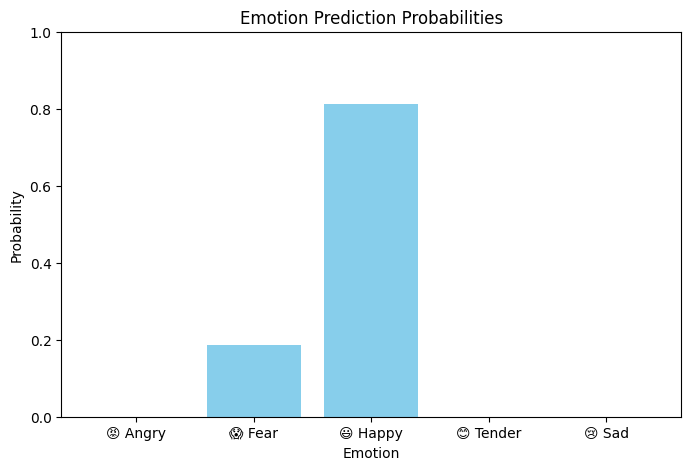

In [73]:
from huggingface_hub import hf_hub_download
import torch

# Hugging Face 저장소에서 PyTorch 모델 불러오기
model_name = "jeonghyeon97/music_emontion_classifier_2"
filename = "pytorch_model.bin"  # 업로드한 파일 이름

# Hugging Face Hub에서 모델 다운로드
model_path = hf_hub_download(repo_id=model_name, filename=filename)

# 모델 로드
model = CNNEmotionClassifier(num_classes=5)
model.load_state_dict(torch.load(model_path))
model.to(device)


# 예측 함수 사용 예시
base_path = "/content/drive/MyDrive/sentiment_classification_projects_241014/music_sentiments_classification/"
# audio_file_path = base_path + "OSF_IO/Set1/002.mp3"
audio_file_path = base_path + "my_test/JingleBells.mp3"
predict_emotion_from_audio(model, audio_file_path)


##

In [72]:
import torch
import torchaudio
from sklearn.model_selection import train_test_split


# 새로운 데이터셋 경로와 CSV 파일 경로
new_eval_csv_file_path1 = '/content/drive/MyDrive/sentiment_classification_projects_241014/music_sentiments_classification/OSF_IO/set1_labeled.csv'
new_eval_data1 = pd.read_csv(new_eval_csv_file_path1)


# 오디오 파일 경로 설정 함수
def get_new_eval_audio_path(set, number):
    song_num_str = str(number).zfill(3)
    return f'/content/drive/MyDrive/sentiment_classification_projects_241014/music_sentiments_classification/OSF_IO/{set}/{song_num_str}.mp3'

new_eval_data1['audio_path'] = new_eval_data1.apply(lambda row: get_new_eval_audio_path("Set1", row['Nro']), axis=1)


# Dataset 설정 (이전과 동일한 방식)
eval_dataset = AudioSpectrogramDataset(new_eval_data1)

# DataLoader 설정
eval_loader = DataLoader(eval_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# 모델을 평가 모드로 전환
model.eval()

# 평가 메트릭 계산 (예: 정확도)
correct = 0
total = 0

with torch.no_grad():
    for batch in eval_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 정확도 출력
accuracy = 100 * correct / total
print(f'Accuracy on new dataset: {accuracy}%')


Accuracy on new dataset: 81.12391930835734%
